In [92]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from scipy.fft import fft
from scipy.signal import find_peaks
from scipy.spatial import Delaunay
import mediapipe as mp
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

In [93]:
# Initialize MediaPipe
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.3,
    min_tracking_confidence=0.5
)
mp_drawing = mp.solutions.drawing_utils

In [94]:
# --- Landmark Indices ---
left_brow_idx = [70, 63, 105, 66, 107, 55, 65, 52, 53, 46]
right_brow_idx = [300, 293, 334, 296, 336, 285, 295, 282, 283, 276]
inner_brow_idx = [63, 293]
brow_landmarks_idx = list(set(left_brow_idx + right_brow_idx + inner_brow_idx))

left_cheek_idx = [205, 206, 216, 204, 207, 114, 115, 116, 213, 214, 215]
right_cheek_idx = [425, 426, 436, 424, 427, 343, 344, 345, 433, 434, 435]
cheek_landmarks_idx = list(set(left_cheek_idx + right_cheek_idx))

left_eye_idx = [33, 160, 158, 133, 153, 144, 145, 159]
right_eye_idx = [362, 385, 387, 263, 373, 374, 380, 386]
outer_eye_idx = [33, 133, 362, 263]
eye_landmarks_idx = list(set(left_eye_idx + right_eye_idx + outer_eye_idx))

jaw_landmarks_idx = [152, 176, 136, 172, 397, 365, 366, 379, 400, 378, 377]

lip_landmarks_idx = [13, 14, 37, 39, 40, 61, 78, 80, 81, 82, 84, 91, 95, 146, 178, 181, 185, 191, 267, 269, 270, 291, 308, 310, 311, 312, 314, 321, 324, 375, 402, 405, 409, 415]

mouth_landmarks_idx = [13, 14, 17, 37, 39, 40, 61, 78, 80, 81, 82, 84, 87, 88, 91, 95, 146, 178, 181, 185, 191, 267, 269, 270, 291, 308, 310, 311, 312, 314, 317, 318, 321, 324, 375, 402, 405, 409, 415]

# --- LEFT / RIGHT Surface Vector Splits ---
left_brow_idx_surface = [70, 63, 105, 66, 107, 55, 65, 52, 53, 46]
right_brow_idx_surface = [300, 293, 334, 296, 336, 285, 295, 282, 283, 276]

left_cheek_idx_surface = [205, 206, 216, 204, 207, 114, 115, 116]
right_cheek_idx_surface = [425, 426, 436, 424, 427, 343, 344, 345]

left_eye_idx_surface = [33, 160, 158, 133, 153, 144, 145, 159]
right_eye_idx_surface = [362, 385, 387, 263, 373, 374, 380, 386]

left_jaw_idx_surface = [152, 176, 136, 172]
right_jaw_idx_surface = [397, 365, 366, 379, 400, 378, 377]

left_lip_idx_surface = [61, 78, 80, 81, 82, 84, 91, 95]
right_lip_idx_surface = [291, 308, 310, 311, 312, 314, 321, 324]

left_mouth_idx_surface = [61, 78, 80, 81, 82, 84, 87, 88, 91, 95, 17]
right_mouth_idx_surface = [291, 308, 310, 311, 312, 314, 317, 318, 321, 324, 375]


In [95]:
# --- Buffers ---
buffer_size = 10
brow_raise_buffer = deque(maxlen=buffer_size)
brow_left_raise_buffer = deque(maxlen=buffer_size)
brow_right_raise_buffer = deque(maxlen=buffer_size)
brow_inner_raise_buffer = deque(maxlen=buffer_size)
brow_vel_buffer = deque(maxlen=buffer_size)
brow_surface_var_buffer = deque(maxlen=buffer_size)
brow_surface_dir_buffer = deque(maxlen=buffer_size)

cheek_raise_buffer = deque(maxlen=buffer_size)
cheek_vel_buffer = deque(maxlen=buffer_size)
cheek_surface_var_buffer = deque(maxlen=buffer_size)
cheek_surface_dir_buffer = deque(maxlen=buffer_size)

eye_ratio_buffer = deque(maxlen=buffer_size)
eye_vel_buffer = deque(maxlen=buffer_size)
blink_buffer = deque(maxlen=30)
eye_surface_var_buffer = deque(maxlen=buffer_size)
eye_surface_dir_buffer = deque(maxlen=buffer_size)

jaw_open_buffer = deque(maxlen=buffer_size)
jaw_vel_buffer = deque(maxlen=buffer_size)
jaw_surface_var_buffer = deque(maxlen=buffer_size)
jaw_surface_dir_buffer = deque(maxlen=buffer_size)

lips_open_buffer = deque(maxlen=buffer_size)
lips_vel_buffer = deque(maxlen=buffer_size)
lips_surface_var_buffer = deque(maxlen=buffer_size)
lips_surface_dir_buffer = deque(maxlen=buffer_size)

mouth_open_buffer = deque(maxlen=buffer_size)
mouth_vel_buffer = deque(maxlen=buffer_size)
mouth_surface_var_buffer = deque(maxlen=buffer_size)
mouth_surface_dir_buffer = deque(maxlen=buffer_size)

In [96]:
# --- Global ---
frame_global = None
features_global = {
    'Eye': {}, 'Brow': {}, 'Cheek': {}, 'Mouth': {}, 'Lips': {}, 'Jaw': {}
}
prev_landmarks_global = None

In [97]:
# --- Surface Vector Split Function ---
def compute_surface_vectors_split(landmarks, prev_landmarks, left_idx, right_idx):
    if prev_landmarks is None or landmarks is None:
        zero = {'vectors': np.array([]), 'positions': [], 'norms': np.array([]), 'mean_mag': 0.0, 'var': 0.0, 'angle': 0.0}
        return {'left': zero, 'right': zero}

    def process_side(idx_list):
        if not idx_list:
            return {'vectors': np.array([]), 'positions': [], 'norms': np.array([]), 'mean_mag': 0.0, 'var': 0.0, 'angle': 0.0}

        curr_pos = []
        prev_pos = []
        for idx in idx_list:
            if idx >= len(landmarks) or idx >= len(prev_landmarks):
                continue
            curr_pos.append(np.array(landmarks[idx]))
            prev_pos.append(np.array(prev_landmarks[idx]))

        if len(curr_pos) < 3:
            return {'vectors': np.array([]), 'positions': [], 'norms': np.array([]), 'mean_mag': 0.0, 'var': 0.0, 'angle': 0.0}

        points2d = np.array([p[:2] for p in curr_pos])

        try:
            tri = Delaunay(points2d)
        except:
            return {'vectors': np.array([]), 'positions': [], 'norms': np.array([]), 'mean_mag': 0.0, 'var': 0.0, 'angle': 0.0}

        triangle_norms = []
        triangle_vectors = []
        triangle_areas = []

        for simplex in tri.simplices:
            i1, i2, i3 = simplex
            v1 = curr_pos[i1] - prev_pos[i1]
            v2 = curr_pos[i2] - prev_pos[i2]
            v3 = curr_pos[i3] - prev_pos[i3]
            mean_v = (v1 + v2 + v3) / 3
            norm = np.linalg.norm(mean_v)
            triangle_norms.append(norm)
            if norm > 1e-6:
                triangle_vectors.append(mean_v / norm)
            else:
                triangle_vectors.append(mean_v)
            area = 0.5 * np.abs(np.cross(points2d[i2] - points2d[i1], points2d[i3] - points2d[i1]))
            triangle_areas.append(area)

        triangle_norms = np.array(triangle_norms)
        mean_mag = np.mean(triangle_norms) if len(triangle_norms) > 0 else 0.0
        var = np.var(triangle_norms) if len(triangle_norms) > 0 else 0.0

        angle = 0.0
        if triangle_vectors and triangle_areas:
            weighted_vectors = np.array(triangle_vectors) * np.array(triangle_areas)[:, np.newaxis]
            avg = np.sum(weighted_vectors[:, :2], axis=0) / np.sum(triangle_areas)
            n = np.linalg.norm(avg)
            if n > 1e-6:
                angle = np.arctan2(avg[1], avg[0])

        vectors = np.array(triangle_vectors) if triangle_vectors else np.array([])
        norms = triangle_norms
        positions = [np.mean([curr_pos[i] for i in s], axis=0) for s in tri.simplices]

        return {'vectors': vectors, 'positions': positions, 'norms': norms, 'mean_mag': mean_mag, 'var': var, 'angle': angle}

    return {'left': process_side(left_idx), 'right': process_side(right_idx)}


In [98]:
# --- BROW ---
def compute_brow_features(landmarks, prev_landmarks):
    if landmarks is None: return {}
    nose_tip = np.array(landmarks[1])
    norm_landmarks = [np.array(lm) - nose_tip for lm in landmarks]

    left_brow_ys = [norm_landmarks[i][1] for i in left_brow_idx]
    right_brow_ys = [norm_landmarks[i][1] for i in right_brow_idx]
    inner_brow_ys = [norm_landmarks[i][1] for i in inner_brow_idx]

    left_raise = -np.mean(left_brow_ys)
    right_raise = -np.mean(right_brow_ys)
    inner_raise = -np.mean(inner_brow_ys)
    overall_raise = (left_raise + right_raise) / 2

    brow_left_raise_buffer.append(left_raise)
    brow_right_raise_buffer.append(right_raise)
    brow_inner_raise_buffer.append(inner_raise)
    brow_raise_buffer.append(overall_raise)

    left_stats = [np.mean(brow_left_raise_buffer), np.std(brow_left_raise_buffer)] if len(brow_left_raise_buffer) > 1 else [0, 0]
    right_stats = [np.mean(brow_right_raise_buffer), np.std(brow_right_raise_buffer)] if len(brow_right_raise_buffer) > 1 else [0, 0]
    inner_stats = [np.mean(brow_inner_raise_buffer), np.std(brow_inner_raise_buffer)] if len(brow_inner_raise_buffer) > 1 else [0, 0]

    brow_vel = abs(overall_raise - brow_raise_buffer[-2]) if len(brow_raise_buffer) > 1 else 0
    brow_vel_buffer.append(brow_vel)
    vel_stats = [np.mean(brow_vel_buffer), np.std(brow_vel_buffer)] if len(brow_vel_buffer) > 1 else [0, 0]
    rapid_count = len(find_peaks(list(brow_vel_buffer), distance=2)[0]) if len(brow_vel_buffer) > 1 else 0

    micro_var = np.var(brow_raise_buffer) if len(brow_raise_buffer) > 1 else 0.0
    freq_mean = np.mean(np.abs(fft(list(brow_raise_buffer)))[:buffer_size//2]) if len(brow_raise_buffer) == buffer_size else 0.0
    peak_freq = np.max(np.abs(fft(list(brow_raise_buffer)))[:buffer_size//2]) if len(brow_raise_buffer) == buffer_size else 0.0

    brow_asym = abs(left_raise - right_raise)
    inner_asym = abs(norm_landmarks[63][1] - norm_landmarks[293][1])
    asym_diffs = np.abs(np.array(brow_left_raise_buffer) - np.array(brow_right_raise_buffer))
    temp_asym_var = np.var(asym_diffs) if len(asym_diffs) > 1 else 0.0

    surface = compute_surface_vectors_split(landmarks, prev_landmarks, left_brow_idx_surface, right_brow_idx_surface)
    left, right = surface['left'], surface['right']

    brow_surface_var_buffer.append({'left': left['var'], 'right': right['var']})
    brow_surface_dir_buffer.append({'left': left['angle'], 'right': right['angle']})

    left_vars = [x['left'] for x in list(brow_surface_var_buffer)[-10:]]
    right_vars = [x['right'] for x in list(brow_surface_var_buffer)[-10:]]
    left_angles = [x['left'] for x in list(brow_surface_dir_buffer)[-10:]]
    right_angles = [x['right'] for x in list(brow_surface_dir_buffer)[-10:]]

    var_stats_l = [np.mean(left_vars), np.std(left_vars), np.min(left_vars), np.max(left_vars)] if left_vars else [0]*4
    var_stats_r = [np.mean(right_vars), np.std(right_vars), np.min(right_vars), np.max(right_vars)] if right_vars else [0]*4
    dir_stats_l = [np.mean(left_angles), np.std(left_angles)] if len(left_angles) > 1 else [0, 0]
    dir_stats_r = [np.mean(right_angles), np.std(right_angles)] if len(right_angles) > 1 else [0, 0]

    return {
        'Brow micro-expression variance mean': micro_var,
        'Brow micro-expression rapid changes count': rapid_count,
        'Brow velocity (mean)': vel_stats[0],
        'Brow velocity (std)': vel_stats[1],
        'Right brow raise (mean)': right_stats[0],
        'Right brow raise (std)': right_stats[1],
        'Left brow raise (mean)': left_stats[0],
        'Left brow raise (std)': left_stats[1],
        'Inner brow raise (mean)': inner_stats[0],
        'Inner brow raise (std)': inner_stats[1],
        'Brow asymmetry (mean)': brow_asym,
        'Temporal brow asymmetry variance': temp_asym_var,
        'Brow frequency mean': freq_mean,
        'Brow peak frequency': peak_freq,

        'Left surface vector magnitude mean': left['mean_mag'],
        'Left surface variance (current)': left['var'],
        'Left surface variance mean': var_stats_l[0],
        'Left surface variance std': var_stats_l[1],
        'Left surface variance min': var_stats_l[2],
        'Left surface variance max': var_stats_l[3],
        'Left surface dominant angle mean': dir_stats_l[0],
        'Left surface dominant angle std': dir_stats_l[1],

        'Right surface vector magnitude mean': right['mean_mag'],
        'Right surface variance (current)': right['var'],
        'Right surface variance mean': var_stats_r[0],
        'Right surface variance std': var_stats_r[1],
        'Right surface variance min': var_stats_r[2],
        'Right surface variance max': var_stats_r[3],
        'Right surface dominant angle mean': dir_stats_r[0],
        'Right surface dominant angle std': dir_stats_r[1],
    }


# --- CHEEK ---
def compute_cheek_features(landmarks, prev_landmarks):
    if landmarks is None: return {}
    nose_tip = np.array(landmarks[1])
    norm_landmarks = [np.array(lm) - nose_tip for lm in landmarks]

    left_ys = [norm_landmarks[i][1] for i in left_cheek_idx if i < len(norm_landmarks)]
    left_xs = [norm_landmarks[i][0] for i in left_cheek_idx if i < len(norm_landmarks)]
    right_ys = [norm_landmarks[i][1] for i in right_cheek_idx if i < len(norm_landmarks)]
    right_xs = [norm_landmarks[i][0] for i in right_cheek_idx if i < len(norm_landmarks)]

    left_raise = -np.mean(left_ys) + np.mean(left_xs) if left_ys else 0
    right_raise = -np.mean(right_ys) + np.mean(right_xs) if right_ys else 0
    overall = (left_raise + right_raise) / 2

    cheek_raise_buffer.append(overall)
    stats = [np.mean(cheek_raise_buffer), np.std(cheek_raise_buffer)] if len(cheek_raise_buffer) > 1 else [0, 0]
    vel = abs(overall - cheek_raise_buffer[-2]) if len(cheek_raise_buffer) > 1 else 0
    cheek_vel_buffer.append(vel)
    vel_stats = [np.mean(cheek_vel_buffer), np.std(cheek_vel_buffer)] if len(cheek_vel_buffer) > 1 else [0, 0]
    rapid = len(find_peaks(list(cheek_vel_buffer), distance=2)[0]) if len(cheek_vel_buffer) > 1 else 0
    var = np.var(cheek_raise_buffer) if len(cheek_raise_buffer) > 1 else 0
    freq = np.mean(np.abs(fft(list(cheek_raise_buffer)))[:buffer_size//2]) if len(cheek_raise_buffer) == buffer_size else 0

    asym = abs(left_raise - right_raise)
    surface = compute_surface_vectors_split(landmarks, prev_landmarks, left_cheek_idx_surface, right_cheek_idx_surface)
    l, r = surface['left'], surface['right']
    cheek_surface_var_buffer.append({'left': l['var'], 'right': r['var']})
    cheek_surface_dir_buffer.append({'left': l['angle'], 'right': r['angle']})

    lv = [x['left'] for x in list(cheek_surface_var_buffer)[-10:]]
    rv = [x['right'] for x in list(cheek_surface_var_buffer)[-10:]]
    la = [x['left'] for x in list(cheek_surface_dir_buffer)[-10:]]
    ra = [x['right'] for x in list(cheek_surface_dir_buffer)[-10:]]

    vl = [np.mean(lv), np.std(lv), np.min(lv), np.max(lv)] if lv else [0]*4
    vr = [np.mean(rv), np.std(rv), np.min(rv), np.max(rv)] if rv else [0]*4
    dl = [np.mean(la), np.std(la)] if len(la) > 1 else [0, 0]
    dr = [np.mean(ra), np.std(ra)] if len(ra) > 1 else [0, 0]

    return {
        'Cheek puff micro-expression variance mean': var,
        'Cheek puff rapid changes count': rapid,
        'Cheek raise (mean)': stats[0],
        'Cheek raise (std)': stats[1],
        'Cheek velocity (mean)': vel_stats[0],
        'Cheek velocity (std)': vel_stats[1],
        'Cheek frequency mean': freq,
        'Cheek asymmetry (mean)': asym,

        'Left surface vector magnitude mean': l['mean_mag'],
        'Left surface variance (current)': l['var'],
        'Left surface variance mean': vl[0],
        'Left surface variance std': vl[1],
        'Left surface variance min': vl[2],
        'Left surface variance max': vl[3],
        'Left surface dominant angle mean': dl[0],
        'Left surface dominant angle std': dl[1],

        'Right surface vector magnitude mean': r['mean_mag'],
        'Right surface variance (current)': r['var'],
        'Right surface variance mean': vr[0],
        'Right surface variance std': vr[1],
        'Right surface variance min': vr[2],
        'Right surface variance max': vr[3],
        'Right surface dominant angle mean': dr[0],
        'Right surface dominant angle std': dr[1],
    }

# --- EYE ---
def compute_eye_features(landmarks, prev_landmarks):
    if landmarks is None: return {}
    nose_tip = np.array(landmarks[1])
    norm_landmarks = [np.array(lm) - nose_tip for lm in landmarks]

    lu = (norm_landmarks[159][1] + norm_landmarks[158][1] + norm_landmarks[160][1]) / 3
    ll = (norm_landmarks[145][1] + norm_landmarks[144][1] + norm_landmarks[153][1]) / 3
    lw = abs(norm_landmarks[33][0] - norm_landmarks[133][0])
    left_ratio = abs(lu - ll) / lw if lw > 0 else 0

    ru = (norm_landmarks[386][1] + norm_landmarks[387][1] + norm_landmarks[385][1]) / 3
    rl = (norm_landmarks[374][1] + norm_landmarks[373][1] + norm_landmarks[380][1]) / 3
    rw = abs(norm_landmarks[362][0] - norm_landmarks[263][0])
    right_ratio = abs(ru - rl) / rw if rw > 0 else 0

    ratio = (left_ratio + right_ratio) / 2
    eye_ratio_buffer.append(ratio)
    stats = [np.mean(eye_ratio_buffer), np.std(eye_ratio_buffer)] if len(eye_ratio_buffer) > 1 else [0, 0]
    vel = abs(ratio - eye_ratio_buffer[-2]) if len(eye_ratio_buffer) > 1 else 0
    eye_vel_buffer.append(vel)
    vel_stats = [np.mean(eye_vel_buffer), np.std(eye_vel_buffer)] if len(eye_vel_buffer) > 1 else [0, 0]
    rapid = len(find_peaks(list(eye_vel_buffer), distance=2)[0]) if len(eye_vel_buffer) > 1 else 0
    var = np.var(eye_ratio_buffer) if len(eye_ratio_buffer) > 1 else 0
    blink = 1 if ratio < 0.1 else 0
    blink_buffer.append(blink)
    blink_rate = sum(blink_buffer) / len(blink_buffer) if blink_buffer else 0

    surface = compute_surface_vectors_split(landmarks, prev_landmarks, left_eye_idx_surface, right_eye_idx_surface)
    l, r = surface['left'], surface['right']
    eye_surface_var_buffer.append({'left': l['var'], 'right': r['var']})
    eye_surface_dir_buffer.append({'left': l['angle'], 'right': r['angle']})

    lv = [x['left'] for x in list(eye_surface_var_buffer)[-10:]]
    rv = [x['right'] for x in list(eye_surface_var_buffer)[-10:]]
    la = [x['left'] for x in list(eye_surface_dir_buffer)[-10:]]
    ra = [x['right'] for x in list(eye_surface_dir_buffer)[-10:]]

    vl = [np.mean(lv), np.std(lv), np.min(lv), np.max(lv)] if lv else [0]*4
    vr = [np.mean(rv), np.std(rv), np.min(rv), np.max(rv)] if rv else [0]*4
    dl = [np.mean(la), np.std(la)] if len(la) > 1 else [0, 0]
    dr = [np.mean(ra), np.std(ra)] if len(ra) > 1 else [0, 0]

    return {
        'Eye widening micro-expression variance mean': var,
        'Eye widening rapid changes count': rapid,
        'Eye ratio (mean)': stats[0],
        'Eye ratio (std)': stats[1],
        'Blink rate': blink_rate,
        'Eye squint velocity (mean)': vel_stats[0],
        'Eye squint velocity (std)': vel_stats[1],

        'Left surface vector magnitude mean': l['mean_mag'],
        'Left surface variance (current)': l['var'],
        'Left surface variance mean': vl[0],
        'Left surface variance std': vl[1],
        'Left surface variance min': vl[2],
        'Left surface variance max': vl[3],
        'Left surface dominant angle mean': dl[0],
        'Left surface dominant angle std': dl[1],

        'Right surface vector magnitude mean': r['mean_mag'],
        'Right surface variance (current)': r['var'],
        'Right surface variance mean': vr[0],
        'Right surface variance std': vr[1],
        'Right surface variance min': vr[2],
        'Right surface variance max': vr[3],
        'Right surface dominant angle mean': dr[0],
        'Right surface dominant angle std': dr[1],
    }

# --- JAW ---
def compute_jaw_features(landmarks, prev_landmarks):
    if landmarks is None: return {}
    nose_tip = np.array(landmarks[1])
    norm_landmarks = [np.array(lm) - nose_tip for lm in landmarks]

    chin = norm_landmarks[152]
    upper_jaw_ref = norm_landmarks[13]
    jaw_open = np.linalg.norm(chin - upper_jaw_ref)
    jaw_open_buffer.append(jaw_open)
    jaw_open_stats = [np.mean(jaw_open_buffer), np.std(jaw_open_buffer), np.min(jaw_open_buffer), np.max(jaw_open_buffer)] if len(jaw_open_buffer) > 1 else [0.0, 0.0, 0.0, 0.0]

    jaw_vel = abs(jaw_open - jaw_open_buffer[-2]) if len(jaw_open_buffer) > 1 else 0
    jaw_vel_buffer.append(jaw_vel)
    jaw_vel_stats = [np.mean(jaw_vel_buffer), np.std(jaw_vel_buffer)] if len(jaw_vel_buffer) > 1 else [0.0, 0.0]

    left_jaw = norm_landmarks[136]
    right_jaw = norm_landmarks[400]
    jaw_asym = np.abs(left_jaw[0] - right_jaw[0])
    jaw_asym_stats = [np.mean([jaw_asym]), np.std([jaw_asym]), np.max([jaw_asym])] if len(jaw_open_buffer) > 1 else [0.0, 0.0, 0.0]

    rapid_count = len(find_peaks(list(jaw_vel_buffer), distance=2)[0]) if len(jaw_vel_buffer) > 1 else 0
    sig_mov_count = sum(1 for v in jaw_vel_buffer if v > 0.001)

    freq_mean = np.mean(np.abs(fft(list(jaw_open_buffer)))[:buffer_size//2]) if len(jaw_open_buffer) == buffer_size else 0.0
    peak_freq = np.max(np.abs(fft(list(jaw_open_buffer)))[:buffer_size//2]) if len(jaw_open_buffer) == buffer_size else 0.0

    surface = compute_surface_vectors_split(landmarks, prev_landmarks, left_jaw_idx_surface, right_jaw_idx_surface)
    l, r = surface['left'], surface['right']
    jaw_surface_var_buffer.append({'left': l['var'], 'right': r['var']})
    jaw_surface_dir_buffer.append({'left': l['angle'], 'right': r['angle']})

    lv = [x['left'] for x in list(jaw_surface_var_buffer)[-10:]]
    rv = [x['right'] for x in list(jaw_surface_var_buffer)[-10:]]
    la = [x['left'] for x in list(jaw_surface_dir_buffer)[-10:]]
    ra = [x['right'] for x in list(jaw_surface_dir_buffer)[-10:]]

    vl = [np.mean(lv), np.std(lv), np.min(lv), np.max(lv)] if lv else [0]*4
    vr = [np.mean(rv), np.std(rv), np.min(rv), np.max(rv)] if rv else [0]*4
    dl = [np.mean(la), np.std(la)] if len(la) > 1 else [0, 0]
    dr = [np.mean(ra), np.std(ra)] if len(ra) > 1 else [0, 0]

    return {
        'Jaw opening (mean)': jaw_open_stats[0],
        'Jaw opening (std)': jaw_open_stats[1],
        'Jaw opening (min)': jaw_open_stats[2],
        'Jaw opening (max)': jaw_open_stats[3],
        'Jaw velocity (mean)': jaw_vel_stats[0],
        'Jaw velocity (std)': jaw_vel_stats[1],
        'Jaw asymmetry (mean)': jaw_asym_stats[0],
        'Jaw asymmetry (std)': jaw_asym_stats[1],
        'Jaw asymmetry (max)': jaw_asym_stats[2],
        'Jaw rapid changes count': rapid_count,
        'Jaw significant movements count': sig_mov_count,
        'Jaw frequency mean': freq_mean,
        'Jaw peak frequency': peak_freq,

        'Left surface vector magnitude mean': l['mean_mag'],
        'Left surface variance (current)': l['var'],
        'Left surface variance mean': vl[0],
        'Left surface variance std': vl[1],
        'Left surface variance min': vl[2],
        'Left surface variance max': vl[3],
        'Left surface dominant angle mean': dl[0],
        'Left surface dominant angle std': dl[1],

        'Right surface vector magnitude mean': r['mean_mag'],
        'Right surface variance (current)': r['var'],
        'Right surface variance mean': vr[0],
        'Right surface variance std': vr[1],
        'Right surface variance min': vr[2],
        'Right surface variance max': vr[3],
        'Right surface dominant angle mean': dr[0],
        'Right surface dominant angle std': dr[1],
    }

# --- LIPS ---
def compute_lips_features(landmarks, prev_landmarks):
    if landmarks is None: return {}
    nose_tip = np.array(landmarks[1])
    norm_landmarks = [np.array(lm) - nose_tip for lm in landmarks]

    upper_lip = norm_landmarks[13]
    lower_lip = norm_landmarks[14]
    lip_open = np.linalg.norm(upper_lip - lower_lip)
    lips_open_buffer.append(lip_open)
    lip_open_stats = [np.mean(lips_open_buffer), np.std(lips_open_buffer), np.min(lips_open_buffer), np.max(lips_open_buffer)] if len(lips_open_buffer) > 1 else [0.0, 0.0, 0.0, 0.0]

    lip_vel = abs(lip_open - lips_open_buffer[-2]) if len(lips_open_buffer) > 1 else 0
    lips_vel_buffer.append(lip_vel)
    lip_vel_stats = [np.mean(lips_vel_buffer), np.std(lips_vel_buffer)] if len(lips_vel_buffer) > 1 else [0.0, 0.0]

    micro_var = np.var(lips_open_buffer) if len(lips_open_buffer) > 1 else 0.0
    rapid_count = len(find_peaks(list(lips_vel_buffer), distance=2)[0]) if len(lips_vel_buffer) > 1 else 0
    sig_mov_count = sum(1 for v in lips_vel_buffer if v > 0.001)

    freq_mean = np.mean(np.abs(fft(list(lips_open_buffer)))[:buffer_size//2]) if len(lips_open_buffer) == buffer_size else 0.0
    peak_freq = np.max(np.abs(fft(list(lips_open_buffer)))[:buffer_size//2]) if len(lips_open_buffer) == buffer_size else 0.0

    left_corner_y = norm_landmarks[61][1] - norm_landmarks[17][1]
    right_corner_y = norm_landmarks[291][1] - norm_landmarks[17][1]
    corner_asym = np.abs(left_corner_y - right_corner_y)
    corner_asym_stats = [np.mean([corner_asym]), np.std([corner_asym]), np.max([corner_asym])] if len(lips_open_buffer) > 1 else [0.0, 0.0, 0.0]

    surface = compute_surface_vectors_split(landmarks, prev_landmarks, left_lip_idx_surface, right_lip_idx_surface)
    l, r = surface['left'], surface['right']
    lips_surface_var_buffer.append({'left': l['var'], 'right': r['var']})
    lips_surface_dir_buffer.append({'left': l['angle'], 'right': r['angle']})

    lv = [x['left'] for x in list(lips_surface_var_buffer)[-10:]]
    rv = [x['right'] for x in list(lips_surface_var_buffer)[-10:]]
    la = [x['left'] for x in list(lips_surface_dir_buffer)[-10:]]
    ra = [x['right'] for x in list(lips_surface_dir_buffer)[-10:]]

    vl = [np.mean(lv), np.std(lv), np.min(lv), np.max(lv)] if lv else [0]*4
    vr = [np.mean(rv), np.std(rv), np.min(rv), np.max(rv)] if rv else [0]*4
    dl = [np.mean(la), np.std(la)] if len(la) > 1 else [0, 0]
    dr = [np.mean(ra), np.std(ra)] if len(ra) > 1 else [0, 0]

    return {
        'Lip micro-expression variance mean': micro_var,
        'Lip micro-expression rapid changes count': rapid_count,
        'Lip opening (mean)': lip_open_stats[0],
        'Lip opening (std)': lip_open_stats[1],
        'Lip opening (min)': lip_open_stats[2],
        'Lip opening (max)': lip_open_stats[3],
        'Lip velocity (mean)': lip_vel_stats[0],
        'Lip velocity (std)': lip_vel_stats[1],
        'Lip significant movements count': sig_mov_count,
        'Lip frequency mean': freq_mean,
        'Lip peak frequency': peak_freq,
        'Lip corner asymmetry (mean)': corner_asym_stats[0],
        'Lip corner asymmetry (std)': corner_asym_stats[1],
        'Lip corner asymmetry (max)': corner_asym_stats[2],

        'Left surface vector magnitude mean': l['mean_mag'],
        'Left surface variance (current)': l['var'],
        'Left surface variance mean': vl[0],
        'Left surface variance std': vl[1],
        'Left surface variance min': vl[2],
        'Left surface variance max': vl[3],
        'Left surface dominant angle mean': dl[0],
        'Left surface dominant angle std': dl[1],

        'Right surface vector magnitude mean': r['mean_mag'],
        'Right surface variance (current)': r['var'],
        'Right surface variance mean': vr[0],
        'Right surface variance std': vr[1],
        'Right surface variance min': vr[2],
        'Right surface variance max': vr[3],
        'Right surface dominant angle mean': dr[0],
        'Right surface dominant angle std': dr[1],
    }

# --- MOUTH ---
def compute_mouth_features(landmarks, prev_landmarks):
    if landmarks is None: return {}
    nose_tip = np.array(landmarks[1])
    norm_landmarks = [np.array(lm) - nose_tip for lm in landmarks]

    upper_lip = norm_landmarks[13]
    lower_lip = norm_landmarks[14]
    mouth_open = np.linalg.norm(upper_lip - lower_lip)
    mouth_open_buffer.append(mouth_open)
    mouth_open_stats = [np.mean(mouth_open_buffer), np.std(mouth_open_buffer), np.min(mouth_open_buffer), np.max(mouth_open_buffer)] if len(mouth_open_buffer) > 1 else [0.0, 0.0, 0.0, 0.0]

    mouth_vel = abs(mouth_open - mouth_open_buffer[-2]) if len(mouth_open_buffer) > 1 else 0
    mouth_vel_buffer.append(mouth_vel)
    mouth_vel_stats = [np.mean(mouth_vel_buffer), np.std(mouth_vel_buffer)] if len(mouth_vel_buffer) > 1 else [0.0, 0.0]

    micro_var = np.var(mouth_open_buffer) if len(mouth_open_buffer) > 1 else 0.0
    rapid_count = len(find_peaks(list(mouth_vel_buffer), distance=2)[0]) if len(mouth_vel_buffer) > 1 else 0
    sig_mov_count = sum(1 for v in mouth_vel_buffer if v > 0.001)

    freq_mean = np.mean(np.abs(fft(list(mouth_open_buffer)))[:buffer_size//2]) if len(mouth_open_buffer) == buffer_size else 0.0
    peak_freq = np.max(np.abs(fft(list(mouth_open_buffer)))[:buffer_size//2]) if len(mouth_open_buffer) == buffer_size else 0.0

    left_corner_y = norm_landmarks[61][1] - norm_landmarks[17][1]
    right_corner_y = norm_landmarks[291][1] - norm_landmarks[17][1]
    corner_asym = np.abs(left_corner_y - right_corner_y)
    corner_asym_stats = [np.mean([corner_asym]), np.std([corner_asym]), np.max([corner_asym])] if len(mouth_open_buffer) > 1 else [0.0, 0.0, 0.0]

    surface = compute_surface_vectors_split(landmarks, prev_landmarks, left_mouth_idx_surface, right_mouth_idx_surface)
    l, r = surface['left'], surface['right']
    mouth_surface_var_buffer.append({'left': l['var'], 'right': r['var']})
    mouth_surface_dir_buffer.append({'left': l['angle'], 'right': r['angle']})

    lv = [x['left'] for x in list(mouth_surface_var_buffer)[-10:]]
    rv = [x['right'] for x in list(mouth_surface_var_buffer)[-10:]]
    la = [x['left'] for x in list(mouth_surface_dir_buffer)[-10:]]
    ra = [x['right'] for x in list(mouth_surface_dir_buffer)[-10:]]

    vl = [np.mean(lv), np.std(lv), np.min(lv), np.max(lv)] if lv else [0]*4
    vr = [np.mean(rv), np.std(rv), np.min(rv), np.max(rv)] if rv else [0]*4
    dl = [np.mean(la), np.std(la)] if len(la) > 1 else [0, 0]
    dr = [np.mean(ra), np.std(ra)] if len(ra) > 1 else [0, 0]

    return {
        'Mouth micro-expression variance mean': micro_var,
        'Mouth micro-expression rapid changes count': rapid_count,
        'Mouth opening (mean)': mouth_open_stats[0],
        'Mouth opening (std)': mouth_open_stats[1],
        'Mouth opening (min)': mouth_open_stats[2],
        'Mouth opening (max)': mouth_open_stats[3],
        'Mouth velocity (mean)': mouth_vel_stats[0],
        'Mouth velocity (std)': mouth_vel_stats[1],
        'Mouth significant movements count': sig_mov_count,
        'Mouth frequency mean': freq_mean,
        'Mouth peak frequency': peak_freq,
        'Mouth corner asymmetry (mean)': corner_asym_stats[0],
        'Mouth corner asymmetry (std)': corner_asym_stats[1],
        'Mouth corner asymmetry (max)': corner_asym_stats[2],

        'Left surface vector magnitude mean': l['mean_mag'],
        'Left surface variance (current)': l['var'],
        'Left surface variance mean': vl[0],
        'Left surface variance std': vl[1],
        'Left surface variance min': vl[2],
        'Left surface variance max': vl[3],
        'Left surface dominant angle mean': dl[0],
        'Left surface dominant angle std': dl[1],

        'Right surface vector magnitude mean': r['mean_mag'],
        'Right surface variance (current)': r['var'],
        'Right surface variance mean': vr[0],
        'Right surface variance std': vr[1],
        'Right surface variance min': vr[2],
        'Right surface variance max': vr[3],
        'Right surface dominant angle mean': dr[0],
        'Right surface dominant angle std': dr[1],
    }

In [99]:
# --- Video Processing (not used in training, but included for completeness) ---
def process_video():
    global frame_global, features_global, prev_landmarks_global
    cap = cv2.VideoCapture(0)
    prev_landmarks = None

    region_configs = [
        ('Brow', left_brow_idx_surface, right_brow_idx_surface, (0, 255, 0)),
        ('Cheek', left_cheek_idx_surface, right_cheek_idx_surface, (255, 0, 0)),
        ('Eye', left_eye_idx_surface, right_eye_idx_surface, (0, 0, 255)),
        ('Jaw', left_jaw_idx_surface, right_jaw_idx_surface, (255, 255, 0)),
        ('Lips', left_lip_idx_surface, right_lip_idx_surface, (255, 0, 255)),
        ('Mouth', left_mouth_idx_surface, right_mouth_idx_surface, (0, 255, 255)),
    ]

    while True:
        ret, frame = cap.read()
        if not ret: break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb)
        landmarks = None

        if results.multi_face_landmarks:
            lmks = results.multi_face_landmarks[0].landmark
            landmarks = [[lm.x, lm.y, lm.z] for lm in lmks]
            h, w, _ = frame.shape
            for idx in set(brow_landmarks_idx + cheek_landmarks_idx + eye_landmarks_idx + jaw_landmarks_idx + lip_landmarks_idx + mouth_landmarks_idx):
                if idx < len(lmks):
                    lm = lmks[idx]
                    cv2.circle(frame, (int(lm.x * w), int(lm.y * h)), 2, (0, 255, 0), -1)

            # Draw arrows
            for name, l_idx, r_idx, color in region_configs:
                data = compute_surface_vectors_split(landmarks, prev_landmarks, l_idx, r_idx)
                for side_key, side_data in [('left', data['left']), ('right', data['right'])]:
                    positions = side_data['positions']
                    mean_mag = side_data['mean_mag']
                    angle = side_data['angle']

                    if len(positions) == 0 or mean_mag < 0.0008:
                        continue

                    # Compute average direction vector from angle
                    avg_dir = np.array([np.cos(angle), np.sin(angle)])

                    # Compute center position
                    center_pos = np.mean(positions, axis=0) if positions else np.array([0, 0, 0])
                    center_x = int(center_pos[0] * w)
                    center_y = int(center_pos[1] * h)

                    # Scale arrow length
                    base_scale = 20
                    max_length = 25
                    min_length = 3
                    arrow_length = min(max(mean_mag * w * base_scale * 30, min_length), max_length)

                    dx = avg_dir[0] * arrow_length
                    dy = avg_dir[1] * arrow_length

                    end_x = int(center_x + dx)
                    end_y = int(center_y + dy)

                    # Draw the arrow
                    cv2.arrowedLine(frame, (center_x, center_y), (end_x, end_y), color, 1, tipLength=0.25)

                    # Label
                    label = name[0] + ('L' if side_key == 'left' else 'R')
                    cv2.putText(frame, label, (center_x - 20, center_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # Compute features
        features_global.update({
            'Brow': compute_brow_features(landmarks, prev_landmarks),
            'Cheek': compute_cheek_features(landmarks, prev_landmarks),
            'Eye': compute_eye_features(landmarks, prev_landmarks),
            'Jaw': compute_jaw_features(landmarks, prev_landmarks),
            'Lips': compute_lips_features(landmarks, prev_landmarks),
            'Mouth': compute_mouth_features(landmarks, prev_landmarks),
        })

        prev_landmarks = landmarks
        frame_global = frame.copy()
        time.sleep(0.03)

    cap.release()


In [100]:
# --- Reset Buffers ---
def reset_buffers():
    global brow_raise_buffer, brow_left_raise_buffer, brow_right_raise_buffer, brow_inner_raise_buffer, brow_vel_buffer, brow_surface_var_buffer, brow_surface_dir_buffer
    global cheek_raise_buffer, cheek_vel_buffer, cheek_surface_var_buffer, cheek_surface_dir_buffer
    global eye_ratio_buffer, eye_vel_buffer, blink_buffer, eye_surface_var_buffer, eye_surface_dir_buffer
    global jaw_open_buffer, jaw_vel_buffer, jaw_surface_var_buffer, jaw_surface_dir_buffer
    global lips_open_buffer, lips_vel_buffer, lips_surface_var_buffer, lips_surface_dir_buffer
    global mouth_open_buffer, mouth_vel_buffer, mouth_surface_var_buffer, mouth_surface_dir_buffer

    buffer_size = 10
    brow_raise_buffer = deque(maxlen=buffer_size)
    brow_left_raise_buffer = deque(maxlen=buffer_size)
    brow_right_raise_buffer = deque(maxlen=buffer_size)
    brow_inner_raise_buffer = deque(maxlen=buffer_size)
    brow_vel_buffer = deque(maxlen=buffer_size)
    brow_surface_var_buffer = deque(maxlen=buffer_size)
    brow_surface_dir_buffer = deque(maxlen=buffer_size)

    cheek_raise_buffer = deque(maxlen=buffer_size)
    cheek_vel_buffer = deque(maxlen=buffer_size)
    cheek_surface_var_buffer = deque(maxlen=buffer_size)
    cheek_surface_dir_buffer = deque(maxlen=buffer_size)

    eye_ratio_buffer = deque(maxlen=buffer_size)
    eye_vel_buffer = deque(maxlen=buffer_size)
    blink_buffer = deque(maxlen=30)
    eye_surface_var_buffer = deque(maxlen=buffer_size)
    eye_surface_dir_buffer = deque(maxlen=buffer_size)

    jaw_open_buffer = deque(maxlen=buffer_size)
    jaw_vel_buffer = deque(maxlen=buffer_size)
    jaw_surface_var_buffer = deque(maxlen=buffer_size)
    jaw_surface_dir_buffer = deque(maxlen=buffer_size)

    lips_open_buffer = deque(maxlen=buffer_size)
    lips_vel_buffer = deque(maxlen=buffer_size)
    lips_surface_var_buffer = deque(maxlen=buffer_size)
    lips_surface_dir_buffer = deque(maxlen=buffer_size)

    mouth_open_buffer = deque(maxlen=buffer_size)
    mouth_vel_buffer = deque(maxlen=buffer_size)
    mouth_surface_var_buffer = deque(maxlen=buffer_size)
    mouth_surface_dir_buffer = deque(maxlen=buffer_size)

In [101]:
def extract_features_from_video(video_path):
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return []

    # Re-initialize FaceMesh with lower thresholds for better detection
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(
        static_image_mode=False,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.1,  # Lowered from 0.3
        min_tracking_confidence=0.1    # Lowered from 0.5
    )

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video at {video_path}")
        return []

    features_list = []
    frame_count = 0
    detected_count = 0
    prev_landmarks = None  # Assuming this is used in your feature computation

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1

        # Process frame
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_frame)

        if results.multi_face_landmarks:
            detected_count += 1
            landmarks = [(lm.x, lm.y, lm.z) for lm in results.multi_face_landmarks[0].landmark]
            
            # Compute features (assuming your compute_*_features functions are defined)
            brow_features = compute_brow_features(landmarks, prev_landmarks)
            cheek_features = compute_cheek_features(landmarks, prev_landmarks)
            eye_features = compute_eye_features(landmarks, prev_landmarks)
            jaw_features = compute_jaw_features(landmarks, prev_landmarks)
            lips_features = compute_lips_features(landmarks, prev_landmarks)
            mouth_features = compute_mouth_features(landmarks, prev_landmarks)
            
            features = {
                'Brow': brow_features,
                'Cheek': cheek_features,
                'Eye': eye_features,
                'Jaw': jaw_features,
                'Lips': lips_features,
                'Mouth': mouth_features
            }
            features_list.append(features)
            prev_landmarks = landmarks  # Update for next frame
        else:
            if frame_count % 50 == 0:  # Print occasionally to avoid spam
                print(f"Warning: No face detected in frame {frame_count}")

    cap.release()
    face_mesh.close()

    print(f"Processed {frame_count} frames.")
    print(f"Detected faces in {detected_count} frames ({(detected_count / frame_count * 100 if frame_count > 0 else 0):.2f}%).")
    
    if detected_count == 0:
        print("Tip: If no detections, try a different video, check lighting/angle, or further lower confidence thresholds.")
    
    return features_list

### This function takes the nested dictionary of facial features (produced by your MediaPipe-based feature extraction) and converts it into a single flat 1D NumPy array (a vector of numbers). This flat vector is what your PyTorch CNN+LSTM model needs as input for each frame.

In [102]:
# --- Flatten Features ---
def flatten_features(features):
    flat = []
    for region in ['Brow', 'Cheek', 'Eye', 'Jaw', 'Lips', 'Mouth']:
        if region in features:
            for v in features[region].values():
                flat.append(float(v))  # Ensure float
    return np.array(flat)

In [103]:
# --- Load Dataset ---
data_dir = 'expressions'
labels = ['Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']
X = []
y = []
lengths = []

### This section of responsible for loading all the videos from your dataset folder, extracting facial features from each video using MediaPipe, converting them into sequences of flat vectors, and building the training data (X and y) for your PyTorch model.

In [104]:
# --- Load Dataset ---
data_dir = 'expressions'
labels = ['Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']
X = []
y = []
lengths = []  

for label_idx, label in enumerate(labels):
    subdir = os.path.join(data_dir, label)
    if os.path.isdir(subdir):
        for vid in os.listdir(subdir):
            if vid.lower().endswith(('.mp4', '.avi', '.mov')):
                path = os.path.join(subdir, vid)
                features_list = extract_features_from_video(path)
                if features_list:
                    seq = [flatten_features(f) for f in features_list if f]
                    if len(seq) > 0:
                        X.append(seq)
                        y.append(label_idx)
                        lengths.append(len(seq))  # Store length

if len(X) == 0:
    print("No videos found or processed.")
    exit()

Processed 115 frames.
Detected faces in 115 frames (100.00%).
Processed 110 frames.
Detected faces in 110 frames (100.00%).
Processed 120 frames.
Detected faces in 120 frames (100.00%).
Processed 111 frames.
Detected faces in 111 frames (100.00%).
Processed 116 frames.
Detected faces in 116 frames (100.00%).
Processed 112 frames.
Detected faces in 112 frames (100.00%).
Processed 120 frames.
Detected faces in 120 frames (100.00%).
Processed 111 frames.
Detected faces in 111 frames (100.00%).
Processed 106 frames.
Detected faces in 106 frames (100.00%).
Processed 117 frames.
Detected faces in 117 frames (100.00%).
Processed 108 frames.
Detected faces in 108 frames (100.00%).
Processed 127 frames.
Detected faces in 127 frames (100.00%).
Processed 103 frames.
Detected faces in 103 frames (100.00%).
Processed 107 frames.
Detected faces in 107 frames (100.00%).
Processed 119 frames.
Detected faces in 119 frames (100.00%).
Processed 103 frames.
Detected faces in 103 frames (100.00%).
Processe

### This prepares the variable-length video sequences (in X) so they can be batched together and fed efficiently into your PyTorch model (CNN+LSTM). Neural networks require all inputs in a batch to have the same shape, but your videos have different lengths (different number of frames). Padding solves this.

In [105]:
# --- Pad Sequences ---
feature_dim = len(X[0][0]) if X and X[0] else 0
X_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in X]
X_padded = pad_sequence(X_tensors, batch_first=True)
y = torch.tensor(y, dtype=torch.long)
lengths = np.array(lengths)

In [106]:
# --- Split Train/Test ---
num_samples = len(X)
indices = np.arange(num_samples)
np.random.shuffle(indices)
train_size = int(0.8 * num_samples)
train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train = X_padded[train_idx]
y_train = y[train_idx]
train_lengths = lengths[train_idx]

X_test = X_padded[test_idx]
y_test = y[test_idx]
test_lengths = lengths[test_idx]

# --- Compute Class Weights for Imbalance ---
class_weights = compute_class_weight('balanced', classes=np.unique(y.numpy()), y=y.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print(f"Class weights: {class_weights}")

Class weights: tensor([0.9362, 0.9362, 0.9362, 0.9362, 0.9362, 1.9130, 0.9362, 0.9362])


In [107]:
# Convert lengths to torch tensors
train_lengths = torch.tensor(train_lengths, dtype=torch.long)
test_lengths = torch.tensor(test_lengths, dtype=torch.long)

In [108]:
# --- Normalize Features (FIXED) ---
# Step 1: Fit scaler only on real frames (exclude padding)
# X_train is (num_samples, max_seq_len, feature_dim)
train_numpy = X_train.numpy()  # shape: (N, T, F)
real_frames_list = []
for i in range(len(train_numpy)):
    length = train_lengths[i].item()
    real_frames_list.append(train_numpy[i, :length, :])  # take only actual frames

# Concatenate all real frames → (total_real_frames, feature_dim)
all_train_frames = np.concatenate(real_frames_list, axis=0)

scaler = StandardScaler()
scaler.fit(all_train_frames)

StandardScaler()

In [109]:
# Step 2: Apply transform to full padded sequences
def normalize_padded_sequences(padded_tensor):
    """Apply scaler to a padded 3D tensor (batch, seq, feat)"""
    numpy_3d = padded_tensor.numpy()
    N, T, F = numpy_3d.shape
    # Reshape to 2D: (N*T, F)
    flat_2d = numpy_3d.reshape(-1, F)
    # Transform
    transformed_2d = scaler.transform(flat_2d)
    # Reshape back to 3D
    transformed_3d = transformed_2d.reshape(N, T, F)
    return torch.tensor(transformed_3d, dtype=torch.float32)

X_train_norm = normalize_padded_sequences(X_train)
X_test_norm = normalize_padded_sequences(X_test)

print(f"Normalization complete. Feature dim: {X_train_norm.shape[2]}")

Normalization complete. Feature dim: 166


In [110]:
# --- Attention Module ---
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim * 2)  # For bidirectional
        self.v = nn.Linear(hidden_dim * 2, 1, bias=False)

    def forward(self, hidden_states):
        # hidden_states: (batch, seq_len, hidden*2)
        attn_weights = self.v(torch.tanh(self.attn(hidden_states)))
        attn_weights = torch.softmax(attn_weights, dim=1)
        context = torch.sum(attn_weights * hidden_states, dim=1)
        return context

# --- Improved CNN+LSTM Model with Attention ---
class ImprovedCNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=3, dropout=0.5):
        super(ImprovedCNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, 256, kernel_size=3, padding=1),  # Increased filters
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(32, hidden_dim, batch_first=True, num_layers=num_layers, bidirectional=True, dropout=dropout)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        x = x.permute(0, 2, 1)  # (batch, seq, feat) → (batch, feat, seq)
        x = self.cnn(x)         # (batch, 32, seq//4) due to pooling
        x = x.permute(0, 2, 1)  # (batch, seq//4, 32)

        # Adjust lengths for pooling (divide by 4 due to two MaxPool1d layers)
        adjusted_lengths = (lengths.cpu() // 4).clamp(min=1)
        packed = pack_padded_sequence(x, adjusted_lengths, batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.lstm(packed)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)  # (batch, seq//4, hidden*2)

        attn_out = self.attention(lstm_out)  # (batch, hidden*2)
        attn_out = self.dropout(attn_out)
        return self.fc(attn_out)

In [111]:
# --- Initialize Improved Model ---
hidden_dim = 512  # Increased from 256
num_classes = len(labels)
model = ImprovedCNNLSTM(feature_dim, hidden_dim, num_classes, num_layers=3, dropout=0.5)

# Use class-weighted loss to handle imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-3)  # Adjusted LR and weight decay
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)  # T_max should match your epochs

In [113]:
# --- Training Loop with Early Stopping ---
epochs = 150  # Increased from 100
batch_size = 8
best_acc = 0.0
patience = 15  # Increased patience
counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    permutation = torch.randperm(len(X_train_norm))  # Shuffle batches

    for i in range(0, len(X_train_norm), batch_size):
        indices = permutation[i:i+batch_size]
        batch_X = X_train_norm[indices]
        batch_lengths = train_lengths[indices]
        batch_y = y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_X, batch_lengths)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / (len(X_train_norm) // batch_size)
    scheduler.step()  # Updated for CosineAnnealingLR

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_norm, test_lengths)
        val_loss = criterion(val_outputs, y_test).item()
        val_pred = val_outputs.argmax(dim=1)
        val_acc = (val_pred == y_test).float().mean().item()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Save model
    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), 'landmark_facial_expression_model.pth')
        print("  >>> model saved!")
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

Epoch 1/150 | Loss: 1.7657 | Val Loss: 1.4520 | Val Acc: 41.13% | LR: 0.000500
  >>> model saved!
Epoch 2/150 | Loss: 1.6202 | Val Loss: 1.5663 | Val Acc: 36.17% | LR: 0.000500
Epoch 3/150 | Loss: 1.5538 | Val Loss: 1.3506 | Val Acc: 44.68% | LR: 0.000499
  >>> model saved!
Epoch 4/150 | Loss: 1.5454 | Val Loss: 1.3279 | Val Acc: 43.26% | LR: 0.000499
Epoch 5/150 | Loss: 1.4121 | Val Loss: 1.2450 | Val Acc: 47.52% | LR: 0.000498
  >>> model saved!
Epoch 6/150 | Loss: 1.4339 | Val Loss: 1.2964 | Val Acc: 46.10% | LR: 0.000497
Epoch 7/150 | Loss: 1.3556 | Val Loss: 1.2971 | Val Acc: 48.23% | LR: 0.000496
  >>> model saved!
Epoch 8/150 | Loss: 1.3532 | Val Loss: 1.2929 | Val Acc: 44.68% | LR: 0.000496
Epoch 9/150 | Loss: 1.2830 | Val Loss: 1.2467 | Val Acc: 57.45% | LR: 0.000495
  >>> model saved!
Epoch 10/150 | Loss: 1.1517 | Val Loss: 1.2129 | Val Acc: 51.06% | LR: 0.000493
Epoch 11/150 | Loss: 1.0610 | Val Loss: 1.1525 | Val Acc: 58.87% | LR: 0.000492
  >>> model saved!
Epoch 12/150 | 

In [114]:
# --- Final Evaluation with Classification Report and Confusion Matrix ---
from sklearn.metrics import classification_report, accuracy_score

model.load_state_dict(torch.load('landmark_facial_expression_model.pth'))
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_norm, test_lengths)
    test_pred = test_outputs.argmax(dim=1).cpu().numpy()
    test_true = y_test.cpu().numpy()

# Accuracy
acc = accuracy_score(test_true, test_pred)
print(f"Final Test Accuracy: {acc * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(test_true, test_pred, target_names=labels))

Final Test Accuracy: 71.63%

Classification Report:
              precision    recall  f1-score   support

       Angry       0.88      0.94      0.91        16
        Calm       0.52      0.80      0.63        15
     Disgust       0.64      0.70      0.67        23
     Fearful       0.83      0.75      0.79        20
       Happy       0.83      0.67      0.74        15
     Neutral       0.80      0.86      0.83        14
         Sad       0.67      0.29      0.40        21
   Surprised       0.68      0.88      0.77        17

    accuracy                           0.72       141
   macro avg       0.73      0.73      0.72       141
weighted avg       0.73      0.72      0.70       141



In [115]:
# Confusion Matrix
cm = confusion_matrix(test_true, test_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[15  0  0  0  0  1  0  0]
 [ 0 12  0  0  1  1  1  0]
 [ 0  3 16  2  0  0  1  1]
 [ 2  0  1 15  0  0  0  2]
 [ 0  1  1  0 10  0  0  3]
 [ 0  1  0  0  0 12  1  0]
 [ 0  6  6  0  1  1  6  1]
 [ 0  0  1  1  0  0  0 15]]


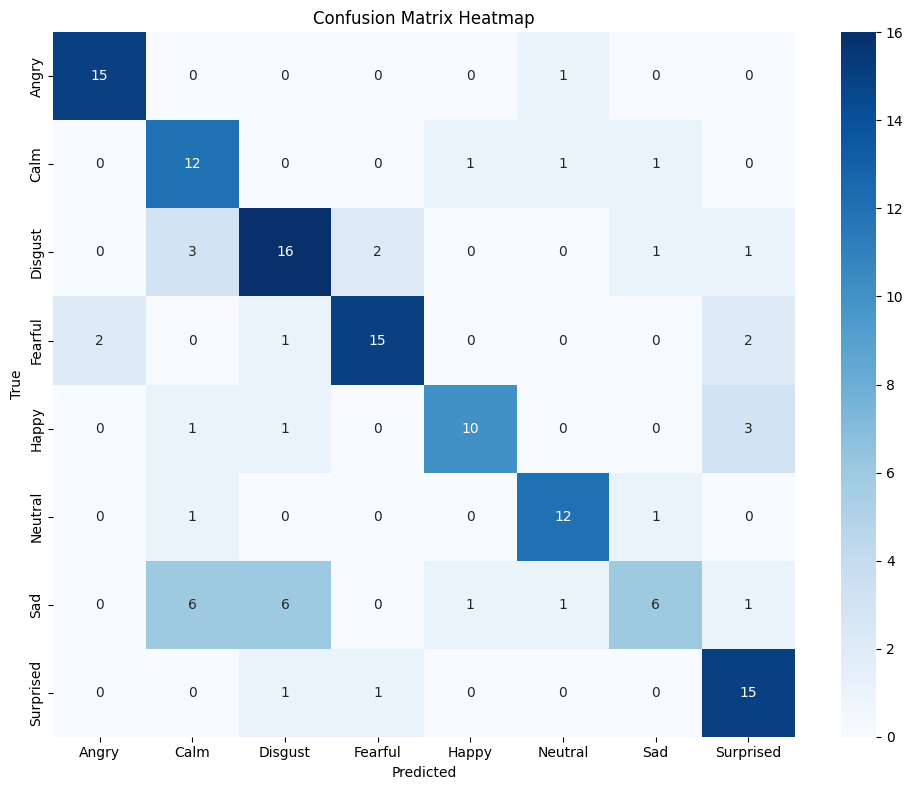

Heatmap saved as 'confusion_heatmap.png'


In [116]:
# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.savefig('confusion_heatmap.png')
plt.show()
print("Heatmap saved as 'confusion_heatmap.png'")

In [126]:
# --- Test on a New Video ---
test_video_path = os.path.join('testing', 'Surprised', '01-01-08-01-01-01-13.mp4')

# Extract features from the video
print(f"Testing on: {test_video_path}")
print(f"File exists: {os.path.exists(test_video_path)}")

features_list = extract_features_from_video(test_video_path)

if not features_list or len(features_list) == 0:
    print("No facial features detected in the video.")
else:
    print(f"Extracted features from {len(features_list)} frames.")

    # Flatten each frame's features into a vector
    seq = []
    for f in features_list:
        flattened = flatten_features(f)
        if flattened is not None:  # Safety check
            seq.append(flattened)
    
    if len(seq) == 0:
        print("No valid feature vectors after flattening.")
    else:
        print(f"Processed {len(seq)} valid feature vectors.")

        # Get max sequence length from training (assuming X_padded exists)
        max_seq_len = X_padded.shape[1]
        feature_dim = X_padded.shape[2]

        # Create padded array: (1, max_seq_len, feature_dim)
        padded_seq = np.zeros((1, max_seq_len, feature_dim), dtype=np.float32)
        actual_length = min(len(seq), max_seq_len)
        padded_seq[0, :actual_length, :] = seq[:actual_length]

        # Convert to torch tensor
        padded_tensor = torch.tensor(padded_seq, dtype=torch.float32)

        # Normalize using the SAME scaler from training
        test_tensor = normalize_padded_sequences(padded_tensor)  # This returns a torch tensor

        # Length tensor
        test_length = torch.tensor([actual_length], dtype=torch.long)

        # Load best model and predict
        model.load_state_dict(torch.load('landmark_facial_expression_model.pth'))
        model.eval()

        with torch.no_grad():
            output = model(test_tensor, test_length)
            probabilities = torch.softmax(output, dim=1)[0]
            pred_idx = output.argmax(dim=1).item()
            confidence = probabilities[pred_idx].item()

            predicted_expression = labels[pred_idx]

        print("\n" + "="*50)
        print(f"PREDICTED EXPRESSION: {predicted_expression.upper()}")
        print(f"Confidence: {confidence * 100:.2f}%")
        print("="*50)

        # Optional: Show top-3 predictions
        print("\nTop 3 Predictions:")
        topk_vals, topk_idx = torch.topk(probabilities, 3)
        for i in range(3):
            expr = labels[topk_idx[i]]
            conf = topk_vals[i].item() * 100
            print(f"  {i+1}. {expr:<10} : {conf:.2f}%")

Testing on: testing\Surprised\01-01-08-01-01-01-13.mp4
File exists: True
Processed 102 frames.
Detected faces in 102 frames (100.00%).
Extracted features from 102 frames.
Processed 102 valid feature vectors.

PREDICTED EXPRESSION: SURPRISED
Confidence: 90.78%

Top 3 Predictions:
  1. Surprised  : 90.78%
  2. Angry      : 3.74%
  3. Fearful    : 3.50%
